# Beta Bank Customer Retention Model

## 1. Introduction
- The objective of this project is to develop a model that will predict whether a client will terminate their contract with Beta Bank.
- The source used to create candidate models for assessment contains data on clients' past behavior and thermination of contracts with the bank.

## 2. Approach
The data shall be preprocessed to ensure it is suitable for model training that the following issues are dealt with:
- Missing Data
- Duplicated Rows
- Improperly Formatted Column Names
- Incorrect Data Types

After preprocessing:
- The DataFrame shall be One-Hot Encoded to transform its categorical features into numerical features for ease of calculation for the Logistic Regression model.
- To avoid falling into a dummy feature trap, the OHE features shall have their first column dropped.
- For the Decision Tree and Random Forest Classifier model, OrdinalEncoder shall be used to improve model performance.

The source data shall then be split into a:
- Training Set (60%)
- Validation Set (20%), and
- Test Set (20%)

To improve balance:
- The numerical columns such as `Age`, `Balance`, and `EstimatedSalary` shall be standardized using feature scaling to support balance in the Logistic Regression model.
- For all of the models listed below, the `class_weight` argument shall be set to 'balanced' to improve the recall score of the minority class.
- The threshold shall also be tuned as-needed to optimize the _F1_ score. 

As the target prediction is determining whether a customer leaves or does not leave, a classification model shall be identified.
The following models from the `sklearn` library shall be assessed for suitability:
- Logistic Regression
- Random Forest Classification

Relevant hyperparameters may be tuned for any of the models listed above with the goal of identifying the model that achieves a minimum _F1_ score of 0.59 on the test set.
The _AUC-ROC_ metric shall also be measured and compared with the _F1_ score.
Finally, baseline sanity check shall be performed to ensure that the leading model beats a "most frequent class" dummy model.

## 3. Initialization
Importing all relevant libraries, load in the dataset, and review the status of data cleanliness.

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.utils import resample, shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, recall_score, precision_score, f1_score, roc_curve, roc_auc_score
from IPython.display import display, HTML

def percent_difference(a, b):
    return abs(a - b) / ((a + b) / 2)

def camel_to_snake(name):
    result = []
    for i, char in enumerate(name):
        if char.isupper() and i!= 0 and not name[i-1].isupper():
            result.append('_')
        result.append(char.lower())
    return ''.join(result)

df = pd.read_csv('../data/Churn.csv')
display(df.info())
print()
print('There are', df.duplicated().sum(), 'duplicated rows.')
print()
display(df.isna().sum())
print()
percent_missing = (df['Tenure'].isnull().sum()/len(df)) * 100
print(f'There are {percent_missing}% of the values missing from the Tenure column.')
print()
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


None


There are 0 duplicated rows.



RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64


There are 9.09% of the values missing from the Tenure column.



,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


## 4. Data Preparation

In [40]:
# Converting all the column names from CamelCase to snake_case
df.columns = [camel_to_snake(col) for col in df.columns]
print(df.columns)

print()

# Updates per feedback
df = df.drop(columns=['row_number', 'customer_id', 'surname']) # Dropping superfluous columns that won't impact the models
print('There are', df.duplicated().sum(), 'duplicated rows.') # Checking for duplicate rows after dropping non-value-add columns

# Replace all of the missing values in the tenure column with average as there are too many missing rows
df['tenure'] = df['tenure'].fillna(df['tenure'].median())
print("There are", df['tenure'].isna().sum(), "missing values in the 'tenure' column now.")

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

There are 0 duplicated rows.
There are 0 missing values in the 'tenure' column now.


- The DataFrame's column names were originally listed in CamelCase and have been converted to snake_case.
- There were 909 missing rows from the `tenure` column, which resulted in 9.09% of the data being missing:
    - This was too significant of a quantity of missing values, and therefore the missing rows in the `tenure` column were replaced with 'Missing" above.
    - None of the other columns were missing data.
- All datatypes were appropriate for their content and did not need conversion.
- The `row_number`, `customer_id`, and `surname` columns were dropped to improve computation cost and improve performance.
- There were no duplicated rows identified in the DataFrame after dropping the identifier columns that did not contribute to the models' performance.

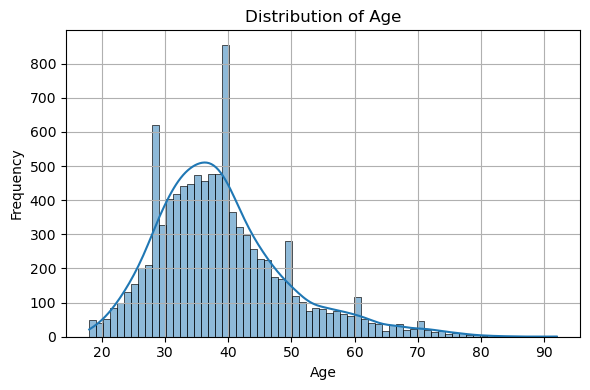

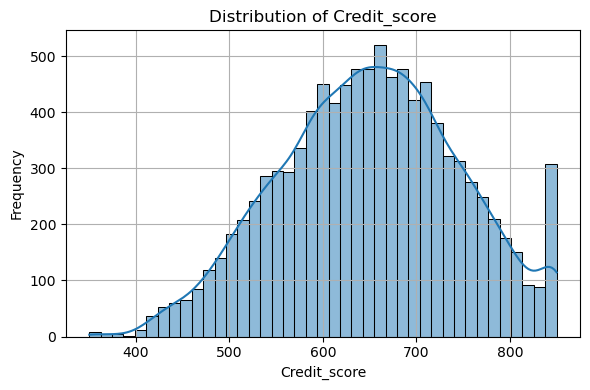

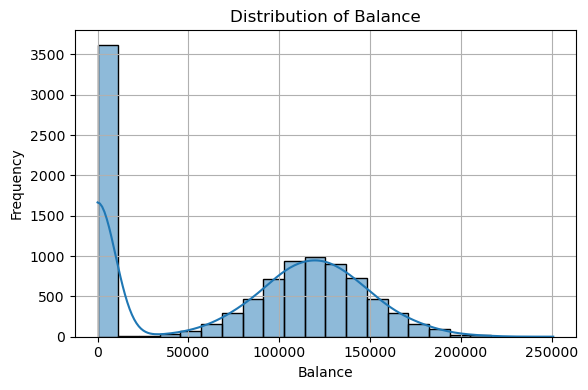

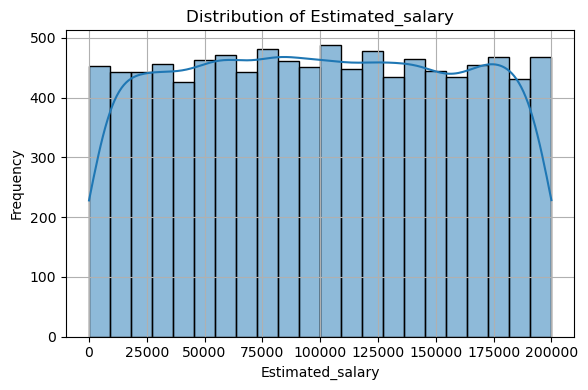

In [41]:
# Create distribution charts for age, credit_score, balance, and estimated_salary columns

cols = ['age', 'credit_score', 'balance', 'estimated_salary']
plot_html = ''
for col in cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col.capitalize()}')
    plt.xlabel(col.capitalize())
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

__COMMENTARY__:
- **Age**:
    - Slightly skewed to the right, with customer ages range from 20 to 90.
    - The majority of customers are between approximately 28 and 40 years old, with exceptionally large numbers of 28 and 40 year old specifically relative to the ages of other customers.
- **Credit Score**:
    - Slightly skewed to the left, with credit scores ranging from sub-400 up to 850.
    - The majority of the customers have credit scores between 575 and 750, however there is a spike at the high end at 850.
- **Balance**:
    - There is  large spike of customers with \$0 balances - this is likely representative of the churned customers that emptied their accounts prior to closing.
    - For the customers that still hold accounts with Beta Bank, the balances are normally distributed around an approximately $125,000 balance mean.
- **Estimated Salary**:
    - Salaries range widely from below `$20,000` up to `$200,000`, with no apparent majority class.
    - The spread of customer salaries appears fairly even across all the bins.

### 4.1 One-Hot Encoding & Data Splitting (Logistic Regression Model)
__One-Hot Encoding__: To ensure that weighting is not erroneously applied by the model, the dataset shall be one-hot encoded for the Logistic Regression model.
- The categorical features will be converted into numericals.
- To avoid the dummy trap, the first column shall be dropped.

__Data-Splitting__:
To align with Machine Learning best practices , the following splits shall be made to ensure proper training and validation occurs:
- Training Set (60%)
- Validation Set (20%)
- Test Set (20%)

In [42]:
# Create a version of the dataset to be used for the Logistic Regression model
df_ohe = pd.get_dummies(df, drop_first=True)

# Using random_state=12345 throughout analysis to ensure reproducible pseudorandomization
lr_training, lr_temp = train_test_split(df_ohe, test_size=0.4, random_state=12345)

#Split the temp set into the validation and test sets
lr_validation, lr_test = train_test_split(lr_temp, test_size=0.5, random_state=12345)

To save time in model assessment in Section 5, we'll establish the features and target variables here.

In [43]:
# Differentiate the features from the targets by dropping the tenure column (the target) for each set
lr_features_train = lr_training.drop(['exited'], axis=1)
lr_target_train = lr_training['exited']

lr_features_valid = lr_validation.drop(['exited'], axis=1)
lr_target_valid = lr_validation['exited']

lr_features_test = lr_test.drop(['exited'], axis=1)
lr_target_test = lr_test['exited']

__Standard Scaling__: The non-binary numerical columns shall now be standardized using feature scaling to support balance for the Logistic Regression model.

In [44]:
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']
scaler = StandardScaler()
lr_features_train[numeric] = scaler.fit_transform(lr_features_train[numeric]) # Fit and transform standard scaling to the training set
lr_features_valid[numeric] = scaler.transform(lr_features_valid[numeric]) # Transform validation and test sets with standard scaling
lr_features_test[numeric] = scaler.transform(lr_features_test[numeric])

The Logistic Regression model's source data is now ready for analysis with prep-processing, splitting, and scaling now complete.

### 4.2 One-Hot Encoding & Data Splitting (Random Forest Classifier Model)
__Ordinal Encoding__: To ensure that weighting is not erroneously applied by the model, the dataset shall be encoded for the Random Forest Classifier model.

- The categorical features will be converted into numericals.
- As tree models do not assume linearity or distance between values, there is no concern for dummy traps, and therefore no columns need to be dropped.

__Data-Splitting__: To align with Machine Learning best practices , the following splits shall be made to ensure proper training and validation occurs:

- Training Set (60%)
- Validation Set (20%)
- Test Set (20%)

In [45]:
# Create a version of the dataset to be used for the Random Forest Classifier model
df_rfc = df

# Using random_state=12345 throughout analysis to ensure reproducible pseudorandomization
rfc_training, rfc_temp = train_test_split(df_rfc, test_size=0.4, random_state=12345)

#Split the temp set into the validation and test sets
rfc_validation, rfc_test = train_test_split(rfc_temp, test_size=0.5, random_state=12345)

# Differentiate the features from the targets by dropping the tenure column (the target) for each set
rfc_features_train = rfc_training.drop(['exited'], axis=1)
rfc_target_train = rfc_training['exited']

rfc_features_valid = rfc_validation.drop(['exited'], axis=1)
rfc_target_valid = rfc_validation['exited']

rfc_features_test = rfc_test.drop(['exited'], axis=1)
rfc_target_test = rfc_test['exited']

# Encoding only the categorical columns
cat_cols = ['geography', 'gender', 'has_cr_card', 'is_active_member']
num_cols = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

# Deploy encoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(rfc_features_train[cat_cols])

# Transform the columns
cat_train_encode = encoder.transform(rfc_features_train[cat_cols])
cat_valid_encode = encoder.transform(rfc_features_valid[cat_cols])
cat_test_encode = encoder.transform(rfc_features_test[cat_cols])

# Convert encoded columns to DataFrame and bring numeric features into the df
encoded_cols = encoder.get_feature_names_out(cat_cols)
cat_train_df = pd.DataFrame(cat_train_encode, columns=encoded_cols, index=rfc_features_train.index)
cat_valid_df = pd.DataFrame(cat_valid_encode, columns=encoded_cols, index=rfc_features_valid.index)
cat_test_df = pd.DataFrame(cat_test_encode, columns=encoded_cols, index=rfc_features_test.index)
rfc_features_train = pd.concat([cat_train_df, rfc_features_train[num_cols]], axis=1)
rfc_features_valid = pd.concat([cat_valid_df, rfc_features_valid[num_cols]], axis=1)
rfc_features_test = pd.concat([cat_test_df, rfc_features_test[num_cols]], axis=1)

## 5. Logistic Regression Model Assessment

### 5.1 Condition of Logistic Regression Model Pre-Balancing 

In [46]:
# Logistic Regression Model Analysis (Pre-Balance Modifications)

results = []
model = LogisticRegression(solver='liblinear', random_state=12345)
model = model.fit(lr_features_train, lr_target_train)

# Create a loop that iterates through the features and targets of each data set, runs the .predict() and .predict_proba() fxs, and summarizes a table
for dataset, features, target in [('Training', lr_features_train, lr_target_train),
                                 ('Validation', lr_features_valid, lr_target_valid)]:
                                 #('Test', lr_features_test, lr_target_test)]:
    target_preds = model.predict(features)
    target_probs = model.predict_proba(features)[:, 1]

    results.append({
        'Set': dataset,
        'F1 Score': f1_score(target, target_preds),
        'AUC-ROC': roc_auc_score(target, target_probs)
    })

lr_summary = pd.DataFrame(results)
print(lr_summary)

          Set  F1 Score   AUC-ROC
0    Training  0.343788  0.777415
1  Validation  0.331081  0.758751


__CONCLUSIONS & COMMENTARY__:
- As the Validation Set F1 Score of ~0.3311 was far below the mandatory minimum 0.59, this model performs poorly in identifying customer churn.
    - The poor performances of both the Training and Validation sets suggest that the model is underfitting.
- The deficiencies here suggest that the model's default classification threshold from `.predict()` (0.5) is insufficient, which supports the premise that class imbalance is having an adverse effect.
- The AUC-ROC Scores being relatively high suggest that the model is somewhat capable of separating the classes, but the poor F1 Scores show that this isn't without significant errors in classification designation.

### 5.2 Logistic Regression Model (Balanced)

In [47]:
# Logistic Regression Model Analysis (Balanced)

thresholds = np.arange(0, 0.9, 0.05) # Testing various thresholds
results = []
model = LogisticRegression(solver='liblinear', random_state=12345, class_weight='balanced') # Updated class_weight param to 'balanced'
model = model.fit(lr_features_train, lr_target_train)

# Create a loop that iterates through the features and targets of each data set, runs the .predict() and .predict_proba() fxs, and summarizes a table
for threshold in thresholds:
    for dataset, features, target in [('Training', lr_features_train, lr_target_train),
                                     ('Validation', lr_features_valid, lr_target_valid)]:
                                     #('Test', lr_features_test, lr_target_test)]:
        target_probs = model.predict_proba(features)[:, 1]
        target_preds = (target_probs >= threshold).astype(int)
        
        results.append({
            'Set': dataset,
            'Threshold': threshold,
            'F1 Score': f1_score(target, target_preds),
            'AUC-ROC': roc_auc_score(target, target_probs)
        })

lr_summary = pd.DataFrame(results)

# F1 Pivot
lr_f1_pivot = lr_summary.pivot(index='Threshold', columns='Set', values='F1 Score')
lr_f1_pivot.columns = [f" {col} F1" for col in lr_f1_pivot.columns]

# AUC ROC Pivot
lr_aucroc_pivot = lr_summary.pivot(index='Threshold', columns='Set', values='AUC-ROC')
lr_aucroc_pivot.columns = [f" {col} AUC-ROC" for col in lr_aucroc_pivot.columns]

# Combo Pivot
lr_summary_pivot = pd.concat([lr_f1_pivot, lr_aucroc_pivot], axis=1)
lr_summary_pivot

,Training F1,Validation F1,Training AUC-ROC,Validation AUC-ROC
Threshold,,,,
0.00,0.332407,0.345740,0.779898,0.763731
0.05,0.332915,0.346313,0.779898,0.763731
0.10,0.341303,0.354237,0.779898,0.763731
0.15,0.359068,0.371300,0.779898,0.763731
0.20,0.379826,0.387004,0.779898,0.763731
0.25,0.400430,0.404541,0.779898,0.763731
0.30,0.424515,0.423292,0.779898,0.763731
0.35,0.443103,0.446900,0.779898,0.763731
0.40,0.463253,0.471879,0.779898,0.763731


In [48]:
# Dial in the highest F1 Score available for the test set
param_setpoints = lr_summary[
    (lr_summary['Set'] == 'Validation') & # Changed filter from 'Test' to 'Validation'
    (lr_summary['F1 Score'] > 0.589)
].sort_values('F1 Score', ascending=False).head(1)

param_setpoints[['Threshold', 'F1 Score', 'AUC-ROC']]

,Threshold,F1 Score,AUC-ROC


__CONCLUSIONS & COMMENTARY__:
- Modifications:
    - The `class_weight` hyperparameter was set to 'balanced' to smooth on class imbalances
    - Threshold was tuned and tested at intervals of 0.05 from 0 to 0.9
- Despite testing across a wide variety of threshold values and balancing the classes, the minimum required F1 Score was not realized in the Validation Set at any of the threshold points.
- The F1 Scores generally improved significantly at the high points in relation to the pre-modified Logistic Regression model, however this model still remains unsatisfactory in its ability correctly predict whether a customer will churn.

## 6. Random Forest Classifier Model Assessment

### 6.1 Random Forest Classifier Model (Pre-Balancing)

In [49]:
# Random Forest Classifier Model (Pre-Balancing Modifications)

# Create placeholders for results and list of estimators and depths to improve performance of Random Forest
results = []
est_values = [10, 25, 50, 100, 200] # Reasonable values for small list of data
depth_values = [3, 7, 15, None] # Covers shallow to deep trees

# Creating a loop for estimator and depth values above to assess initial model fit
for est in est_values:
    for depth in depth_values:
        model = RandomForestClassifier(max_depth=depth, n_estimators=est, random_state=12345)
        model = model.fit(rfc_features_train, rfc_target_train)

        # Create a loop assemble the results table
        for dataset, features, target in [('Training', rfc_features_train, rfc_target_train),
                                 ('Validation', rfc_features_valid, rfc_target_valid)]:
                                 #('Test', rfc_features_test, rfc_target_test)]:
            target_preds = model.predict(features)
            target_probs = model.predict_proba(features)[:, 1]

            results.append({
                'N_Est': est,
                'Depth': depth,
                'Set': dataset,
                'F1 Score': f1_score(target, target_preds),
                'AUC-ROC': roc_auc_score(target, target_probs)
    })

rfc_summary = pd.DataFrame(results)
html = rfc_summary.to_html()
scrollable_html = f"""
<div style="height:500px; overflow:auto; border:1px solid #ccc">
{html}
</div>
"""
display(HTML(scrollable_html))

,N_Est,Depth,Set,F1 Score,AUC-ROC
0,10,3.0,Training,0.290345,0.833384
1,10,3.0,Validation,0.239669,0.827534
2,10,7.0,Training,0.533963,0.880763
3,10,7.0,Validation,0.456747,0.823194
4,10,15.0,Training,0.932862,0.997472
5,10,15.0,Validation,0.571429,0.805735
6,10,NaN,Training,0.960623,0.999361
7,10,NaN,Validation,0.549020,0.812723
8,25,3.0,Training,0.234432,0.838634
9,25,3.0,Validation,0.236515,0.828028


In [50]:
# Dial in the highest F1 Score available for the test set
param_setpoints = rfc_summary[
    (rfc_summary['Set'] == 'Validation') & # Changed filter from 'Test' to 'Validation'
    (rfc_summary['F1 Score'] > 0.589)
].sort_values('F1 Score', ascending=False).head(1)

param_setpoints[['N_Est', 'Depth', 'F1 Score', 'AUC-ROC']]

,N_Est,Depth,F1 Score,AUC-ROC


__CONCLUSIONS & COMMENTARY__:
- Even before tuning, the Random Forest Classifier model demonstrates improvement over the tuned Logistic Regression Model.
- The model above was tested across the following Random Forest hyperparameters:
    - Number of Estimators (10, 25, 50, 100, 200): Ensemble sizes sampling appropriate for a relatively small dataset
    - Depth (3, 7, 15, None): Ranging from shallow to completely pure "to-the-leaf" trees
- The best F1 Score achieved in this line of testing was ~0.5749 where the model had 100 estimators and completely developed and complex trees (max_depth=15).
    - The AUC-ROC Score was 0.825, which reflects a high level of ability for the model to differentiate the classes.
    - These scores show a marked improvement over the tuned Logisitic Regression model, but likely fall short in test prediction accuracy needed to predict churn correctly as required by Beta Bank.

### 6.2 Random Forest Classifier Model (Tuned)

In [51]:
# Random Forest Classifier Model (Balanced and Upsampled)

# Set up for upsampling minority class
train_df = pd.concat([rfc_features_train, rfc_target_train], axis=1)
major = train_df[train_df['exited'] == 0]
minor = train_df[train_df['exited'] == 1]

# Upsample minority class with replacement
minor_upsample = resample(minor,
                         replace=True,
                         n_samples=len(major),
                         random_state=12345)

# Put recombine major and minor classes
upsampled_train_df = pd.concat([major, minor_upsample])

# Shuffle
upsampled_train_df = shuffle(upsampled_train_df, random_state=12345).reset_index(drop=True)

# Separate features/target
upsampled_features_train = upsampled_train_df.drop('exited', axis=1)
upsampled_target_train = upsampled_train_df['exited']


# Create placeholders for results and list of estimators and depths to improve performance of Random Forest
thresholds = np.arange(0, 0.9, 0.05) # Threshold test points
results = []
est_values = [10, 25, 50, 100, 200] # Reasonable values for small list of data
depth_values = [3, 7, 15, None] # Covers shallow to deep trees

# Creating a loop for estimator and depth values above to assess initial model fit
for est in est_values:
    for depth in depth_values:
        model = RandomForestClassifier(max_depth=depth, n_estimators=est, random_state=12345) #, class_weight='balanced') # Balanced class weight
        #model = model.fit(rfc_features_train, rfc_target_train)
        model = model.fit(upsampled_features_train, upsampled_target_train) # Changed to upsampled set

        # Create a loop assemble the results table
        for threshold in thresholds:
            for dataset, features, target in [('Training', rfc_features_train, rfc_target_train),
                                     ('Validation', rfc_features_valid, rfc_target_valid)]:
                                     #('Test', rfc_features_test, rfc_target_test)]:
                target_probs = model.predict_proba(features)[:, 1]
                target_preds = (target_probs >= threshold).astype(int)
                    
                results.append({
                    'N_Est': est,
                    'Depth': depth,
                    'Threshold': threshold,
                    'Set': dataset,
                    'F1 Score': f1_score(target, target_preds),
                    'AUC-ROC': roc_auc_score(target, target_probs)
        })

rfc_summary = pd.DataFrame(results)
html = rfc_summary.to_html()
scrollable_html = f"""
<div style="height:500px; overflow:auto; border:1px solid #ccc">
{html}
</div>
"""
display(HTML(scrollable_html))

,N_Est,Depth,Threshold,Set,F1 Score,AUC-ROC
0,10,3.0,0.00,Training,0.332407,0.843272
1,10,3.0,0.00,Validation,0.345740,0.821773
2,10,3.0,0.05,Training,0.332407,0.843272
3,10,3.0,0.05,Validation,0.345740,0.821773
4,10,3.0,0.10,Training,0.332407,0.843272
5,10,3.0,0.10,Validation,0.345740,0.821773
6,10,3.0,0.15,Training,0.332407,0.843272
7,10,3.0,0.15,Validation,0.345740,0.821773
8,10,3.0,0.20,Training,0.332407,0.843272
9,10,3.0,0.20,Validation,0.345740,0.821773


In [52]:
# Dial in the highest F1 Score available for the test set
param_setpoints = rfc_summary[
    (rfc_summary['Set'] == 'Validation') & # Updated from Test to Validation
    (rfc_summary['F1 Score'] > 0.589)
].sort_values('F1 Score', ascending=False).head(1)

param_setpoints[['Threshold', 'N_Est', 'Depth', 'F1 Score', 'AUC-ROC']]

,Threshold,N_Est,Depth,F1 Score,AUC-ROC
205,0.6,25,7.0,0.624187,0.845814


In [53]:
# Rerunning optimal Random Forest Classifier Model against Test Set
best = rfc_summary[(rfc_summary['Set'] == 'Validation')].sort_values(by='F1 Score', ascending=False).head(1)

best_threshold = best['Threshold'].values[0]
best_n_est = int(best['N_Est'].values[0])
best_depth = int(best['Depth'].values[0])

optimal_rfc = RandomForestClassifier(max_depth=best_depth,
                                    n_estimators=best_n_est,
                                    random_state=12345,)
optimal_rfc.fit(upsampled_features_train, upsampled_target_train)

test_probs = optimal_rfc.predict_proba(rfc_features_test)[:, 1]
test_preds = (test_probs >= best_threshold).astype(int)

test_f1 = f1_score(rfc_target_test, test_preds)
test_auc = roc_auc_score(rfc_target_test, test_probs)

print(f"\nFinal Test Set Evaluation:")
print(f"- F1 Score: {test_f1:.2f}")
print(f"- AUC-ROC:  {test_auc:.2f}")


Final Test Set Evaluation:
- F1 Score: 0.59
- AUC-ROC:  0.84


__CONCLUSIONS & COMMENTARY__:
- Modifications:
    - The `class_weight` hyperparameter previously set to 'balanced' was replaced with upsampling the minority class to smooth out class imbalances
    - The minority class was upsampled with replacement to come up to the level of importance as the majority class
    - Threshold was tuned and tested at intervals of 0.05 from 0 to 0.9
- The model above was tested across the following Random Forest hyperparameters:
    - Number of Estimators (10, 25, 50, 100, 200): Ensemble sizes sampling appropriate for a relatively small dataset
    - Depth (3, 7, 15, None): Ranging from shallow to completely pure "to-the-leaf" trees
- The best F1 Score achieved in this line of testing from the Validation Set was ~0.624 where:
    - Threshold: 0.6, which is greater than the default of 0.5 provided by `.predict()`, and improves on recall.
    - N_Est: 25, which is on the lower end of the Random Forest ensemble training range and lends itself to mitigation of overfitting.
    - Depth: 7, which shows that the model is fairly middle of the road in terms of complexity.
    - AUC-ROC Score: ~0.846, which further improved on the ability for the model to differentiate the classes.
    - These scores show a marked improvement over the tuned Logisitic Regression model, and meets the level of accuracy needed to predict churn correctly as required by Beta Bank.
- When these optimal Validation Set parameters were used to predict against the Test Set, the F1 Score was ~0.59, meeting Beta Bank's minimum score for suitability, and retained a strong AUC-ROC score of 0.84.
- This iteration of the model is what Beta Bank should use to begin predicting churn and taking proactive action to secure revenue.

## 7. Sanity Check (Baseline Model)

In [54]:
# DummyClassifer Model set to 'most-frequent' to naively predict the majority class

# Create a dummy version of the DataFrame for splitting
dummy_df = df

# Using random_state=12345 throughout analysis to ensure reproducible pseudorandomization
dummy_training, dummy_temp = train_test_split(dummy_df, test_size=0.4, random_state=12345)

#Split the temp set into the validation and test sets
dummy_validation, dummy_test = train_test_split(dummy_temp, test_size=0.5, random_state=12345)

# Differentiate the features from the targets by dropping the tenure column (the target) for each set
dummy_features_train = dummy_training.drop(['exited'], axis=1)
dummy_target_train = dummy_training['exited']

dummy_features_valid = dummy_validation.drop(['exited'], axis=1)
dummy_target_valid = dummy_validation['exited']

dummy_features_test = dummy_test.drop(['exited'], axis=1)
dummy_target_test = dummy_test['exited']

# Convert all the features to 0s to introduce constancy into the dataset
dummy_features_train = np.zeros((len(dummy_target_train), 1))
dummy_features_valid = np.zeros((len(dummy_target_valid), 1))
dummy_features_test = np.zeros((len(dummy_target_test), 1))

# Fit the model to the DummyClassifier()
results = []
dummy = DummyClassifier(strategy='most_frequent', random_state=12345)
dummy.fit(dummy_features_train, dummy_target_train)

# Create a loop that iterates through the features and targets of each data set, runs the .predict() and .predict_proba() fxs, and summarizes a table
for dataset, features, target in [('Training', dummy_features_train, dummy_target_train),
                                 ('Validation', dummy_features_valid, dummy_target_valid),
                                 ('Test', dummy_features_test, dummy_target_test)]:
    target_preds = dummy.predict(features)
    target_probs = dummy.predict_proba(features)[:, 1]

    results.append({
        'Set': dataset,
        'F1 Score': f1_score(target, target_preds),
        'AUC-ROC': roc_auc_score(target, target_probs)
    })

dummy_summary = pd.DataFrame(results)
dummy_summary

,Set,F1 Score,AUC-ROC
0,Training,0.0,0.5
1,Validation,0.0,0.5
2,Test,0.0,0.5


__CONCLUSIONS & COMMENTARY__:
- The Dummy Classifier model was brought in to provide a baseline sanity check where the model simply predicts the most common class in the data.
- The improved Random Forest Classifier model passes the baseline sanity check against the Dummy model, with an F1 of 0.848 versus the Dummy Classifier's accuracy of 0.

### 8. Conclusion

__Project Objectives:__
- The objective of this project is to develop a model that will predict whether a client will terminate their contract with Beta Bank.
- The source used to create candidate models for assessment contains data on clients' past behavior and thermination of contracts with the bank.

__Results Summary:__
- **Logistic Regression Model (Pre-Balancing)**:
    - As the Validation Set F1 Score of ~0.3311 was far below the mandatory minimum 0.59, this model performs poorly in identifying customer churn.
    - The poor performances of both the Training and Validation sets suggest that the model is underfitting.
        - The deficiencies here suggest that the model's default classification threshold from `.predict()` (0.5) is insufficient, which supports the premise that class imbalance is having an adverse effect.
        - The AUC-ROC Scores being relatively high suggest that the model is somewhat capable of separating the classes, but the poor F1 Scores show that this isn't without significant errors in classification designation.
- **Logistic Regression Model (Tuned)**:
    - Modifications:
        - The `class_weight` hyperparameter was set to 'balanced' to smooth on class imbalances
        - Threshold was tuned and tested at intervals of 0.05 from 0 to 0.9
    - Despite testing across a wide variety of threshold values and balancing the classes, the minimum required F1 Score was not realized in the Validation Set at any of the threshold points.
    - The F1 Scores generally improved significantly at the high points in relation to the pre-modified Logistic Regression model, however this model still remains unsatisfactory in its ability correctly predict whether a customer will churn.
- **Random Forest Classifier Model (Pre-Balancing)**:
    - Even before tuning, the Random Forest Classifier model demonstrates improvement over the tuned Logistic Regression Model.
    - The model above was tested across the following Random Forest hyperparameters:
        - Number of Estimators (10, 25, 50, 100, 200): Ensemble sizes sampling appropriate for a relatively small dataset
        - Depth (3, 7, 15, None): Ranging from shallow to completely pure "to-the-leaf" trees
    - The best F1 Score achieved in this line of testing was ~0.5749 where the model had 100 estimators and completely developed and complex trees (max_depth=15).
        - The AUC-ROC Score was 0.825, which reflects a high level of ability for the model to differentiate the classes.
        - These scores show a marked improvement over the tuned Logisitic Regression model, but likely fall short in test prediction accuracy needed to predict churn correctly as required by Beta Bank.
- **Random Forest Classifier Model (Tuned)**:
    - Modifications:
        - The `class_weight` hyperparameter previously set to 'balanced' was replaced with upsampling the minority class to smooth out class imbalances
        - The minority class was upsampled with replacement to come up to the level of importance as the majority class
        - Threshold was tuned and tested at intervals of 0.05 from 0 to 0.9
    - The model above was tested across the following Random Forest hyperparameters:
        - Number of Estimators (10, 25, 50, 100, 200): Ensemble sizes sampling appropriate for a relatively small dataset
        - Depth (3, 7, 15, None): Ranging from shallow to completely pure "to-the-leaf" trees
    - The best F1 Score achieved in this line of testing from the Validation Set was ~0.624 where:
        - Threshold: 0.6, which is greater than the default of 0.5 provided by `.predict()`, and improves on recall.
        - N_Est: 25, which is on the lower end of the Random Forest ensemble training range and lends itself to mitigation of overfitting.
        - Depth: 7, which shows that the model is fairly middle of the road in terms of complexity.
        - AUC-ROC Score: ~0.846, which further improved on the ability for the model to differentiate the classes.
        - These scores show a marked improvement over the tuned Logisitic Regression model, and meets the level of accuracy needed to predict churn correctly as required by Beta Bank.
    - When these optimal Validation Set parameters were used to predict against the Test Set, the F1 Score was ~0.59, meeting Beta Bank's minimum score for suitability, and retained a strong AUC-ROC score of 0.84.
    - This iteration of the model is what Beta Bank should use to begin predicting churn and taking proactive action to secure revenue.
      
__Next Steps & Recommendations:__
- Beta Bank should continue to update the source data as more customer behavior data becomes available and continuously train and re-evaluate the tuned Random Forest Classifier Model to further refine it's performance.
    - There may be some opportunity to further tune the hyperparameters via upsampling or downsampling depending on how far the client would like to push the development prior to deployment.
- In its current state, Beta Bank can use this model to better understand the demographic of longstanding clientele and cater their offerings and support towards initiatives that would be attractive and would lead to increased customer retention.
- Understanding whether a high-value customer is a churn-risk could allow for proactive measures to salvage the relationship to play out, such as customer outreach, interest rate offerings, credit card rewards plans, etc.